In [30]:
#imports
import torch
import torch.nn as nn
import torch.nn.functional as F

In [31]:
#submodel class
class Submodel(nn.Module):
    def __init__(self):
        super(Submodel, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5, 1)
        self.conv2 = nn.Conv2d(10, 20, 5, 1)
        self.dropout = nn.Dropout(0.5)
        self.lin1 = nn.Linear(320,50)
        self.lin2 = nn.Linear(50,10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.lin1(x)
        x = F.relu(x)
        return x

In [32]:
#load model with pretrained weights
submodel = Submodel()
submodel.eval()
PATH = 'models/base.pt'
submodel.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [33]:
import os
import cv2
import numpy as np

DIR = 'greek_letters'

images, labels = [], []

#iterate over greek alphabet images
for file in os.listdir(DIR):
    if file.endswith('.png'):
        #read image
        img = cv2.imread(DIR+'/'+file)
        #resize to 28x28
        img = cv2.resize(img, (28,28))
        #convert greyscale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #convert to channel first
        img = img.reshape(-1, 28, 28)
        #get label
        label = file.split('_')[0]
        
        #store as image and label
        images.append(img)
        labels.append(label)

In [34]:
#create embeddings using the submodel
embeddings = []
for img in images:
    embed = submodel(torch.tensor([img], dtype=torch.float32))
    embeddings.append(embed.detach().numpy().flatten())

In [35]:
#convert embeddings and labels to pandas dataframe
import pandas as pd

data = {
    'embedding': embeddings,
    'label': labels
}

df = pd.DataFrame.from_dict(data)

In [36]:
#function to calculate ssd
def ssd(a, b):
    return round(np.sum((a-b)**2), 5)

In [37]:
#get an example for each class
alpha_example = df[df.label=='alpha'].sample(1).iloc[0].embedding
beta_example = df[df.label=='beta'].sample(1).iloc[0].embedding
gamma_example = df[df.label=='gamma'].sample(1).iloc[0].embedding

In [38]:
for idx, row in df.iterrows():
    feature_vector = row.embedding.flatten()
    alpha_example_ssd = ssd(alpha_example, feature_vector)
    beta_example_ssd = ssd(beta_example, feature_vector)
    gamma_example_ssd = ssd(gamma_example, feature_vector)
    print('Row: {}, Label: {}, alpha ssd: {}, beta ssd: {}, gamma ssd: {}'.format(idx, row['label'], alpha_example_ssd, beta_example_ssd, gamma_example_ssd)) 

Row: 0, Label: beta, alpha ssd: 3.3076701164245605, beta ssd: 0.8458899855613708, gamma ssd: 1.114590048789978
Row: 1, Label: alpha, alpha ssd: 5.2890400886535645, beta ssd: 3.6689200401306152, gamma ssd: 5.0160298347473145
Row: 2, Label: alpha, alpha ssd: 2.8343300819396973, beta ssd: 2.602760076522827, gamma ssd: 3.948040008544922
Row: 3, Label: alpha, alpha ssd: 4.613080024719238, beta ssd: 1.8827999830245972, gamma ssd: 3.0979199409484863
Row: 4, Label: gamma, alpha ssd: 23.662370681762695, beta ssd: 22.19215965270996, gamma ssd: 20.976009368896484
Row: 5, Label: gamma, alpha ssd: 13.96090030670166, beta ssd: 11.873350143432617, gamma ssd: 11.737959861755371
Row: 6, Label: gamma, alpha ssd: 27.59284019470215, beta ssd: 25.729089736938477, gamma ssd: 25.30583953857422
Row: 7, Label: alpha, alpha ssd: 4.017139911651611, beta ssd: 2.3863000869750977, gamma ssd: 2.8466899394989014
Row: 8, Label: beta, alpha ssd: 9.519490242004395, beta ssd: 7.966939926147461, gamma ssd: 8.9123096466064

In [44]:
#train KNN model and score
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(embeddings, labels)
knn.score(embeddings, labels)

0.7777777777777778

In [49]:
#iterate over greek alphabet images

images_test, labels_test = [], []

DIR = 'greek_letters_drawn'

for file in os.listdir(DIR):
    if file.endswith('.png'):
        #read image
        img = cv2.imread(DIR+'/'+file)
        #resize to 28x28
        img = cv2.resize(img, (28,28))
        #convert greyscale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #convert to channel first
        img = img.reshape(-1, 28, 28)
        #get label
        label = file.split('.')[0]
        
        #store as image and label
        images_test.append(img)
        labels_test.append(label)

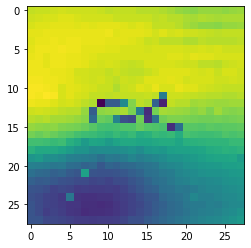

In [50]:
#show 28x28 of drawn greek letters
import matplotlib.pyplot as plt

plt.imshow(images_test[0].reshape(28,28))

In [54]:
#create embeddings using the submodel
embeddings_test = []
for img in images_test:
    embed = submodel(torch.tensor([img], dtype=torch.float32))
    embeddings_test.append(embed.detach().numpy().flatten())

In [55]:
#predict drawn greek letters
knn.score(embeddings_test, labels_test)

0.3333333333333333

In [56]:
labels_test

['alpha', 'gamma', 'beta']